# **Redes de Computadores 1 – Projeto Prático Interdisciplinar**

<a href="https://colab.research.google.com/drive/1WDDr9dJTS5N_2z6gewJQUp3_Bf1-pvFZ#scrollTo=vO0_kZsC0ITc" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Engenharia da Computação – Instituto Federal de Educação, Ciência e Tecnologia de São Paulo, Campus Piracicaba

### Alunos

- [Alexandre Medici Ceregato](mailto:)
- [André Lisboa Augusto](mailto:andre.lisboa@aluno.ifsp.edu.br)
- [Marcos Henrique Maimoni Campanella](mailto:marcos.campanella@aluno.ifsp.edu.br)
- [Rodolfo Henrique Raymundo Engelmann](mailto:rodolfo.engelmann@aluno.ifsp.edu.br)
- [Victor Probio Lopes](mailto:victor.probio@aluno.ifsp.edu.br)

## Introdução

Projeto desenvolvido em conjunto com a matéria de Microcontroladores, ministrada pelo Prof. Pablo Rodrigo de Souza.
O tema deste projeto interdisciplinar foca na coleta e análise de dados climáticos em tempo real, elaborando uma aplicação IoT na qual os aspectos de hardware e software serão desenvolvidos, respectivamente, nas disciplinas de Microcontroladores e Redes de Computadores 1.
</br>
Os dados do tema são coletados no ambiente de cultivo da agricultura de precisão, afim de serem processados adequadamente em prol da tomada de ações que visem melhorar a eficiência geral do plantio.
</br>
Em maiores detalhes, o objetivo do programa desenvolvido é coletar os dados referentes à temperatura, umidade e pressão de um certo local onde se encontra uma placa microcontroladora ESP32 (cujo trabalho é ler os dados e enviá-los para um _broker_ MQTT). Com base nos dados coletados, o programa decide se uma semeadora e/ou uma irrigadora devem ser acionados no local de medição, e envia essas respostas para o _broker_, que são então lidas pelo ESP32, que por sua vez efetua as ações necessárias.
</br>
Além disso, o programa também salva as variáveis climaticas lidas do ESP32 em um arquivo CSV (um segundo por linha). Esse arquivo pode então ser carregado no software novamente para gerar gráficos referentes às medições em um determinado período.

## Materiais e métodos

O presente trabalho foi desenvolvido usando a linguagem de programação Python, funcionando em um _notebook_ Jupyter, programado especificamente para funcionar no serviço de hospedagem de _notebooks_ Google Colaboratory - já que utiliza-se de algumas de suas funcionalidades específicas (como menus e a integração com o Google Drive para hospedagem de arquivos).
</br>
Para o correto funcionamento do software, foi empregado o uso das bibliotecas `paho-mqtt`, `time`, `datetime`, `pandas`, `matplotlib`, `shutil`, `google` e `os`.

## Instruções de uso

Para executar o programa, é necessário executar suas células (partes individuais de código em um _notebook_ Jupyter). Cada Célula possui instruções específicas que podem ser lidas em uma célula textual acima do código. Para executar uma célula, basta mover o _mouse_ para cima desta e clicar sobre o botão de execução, em seu canto superior esquerdo.

### Importação das bibliotecas

**É necessário executar a célula abaixo** para importar as bibliotecas utilizadas.

In [1]:
# BIBLIOTECAS

!pip install paho-mqtt
import paho.mqtt.client as mqtt
import time
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from google.colab import files, drive
import os.path

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for paho-mqtt: filename=paho_mqtt-1.6.1-py3-none-any.whl size=62117 sha256=04821efe31cf712fac7b72aab81608ae9314ca2ae35c1131e5e34ef8e8dc8718
  Stored in directory: /root/.cache/pip/wheels/8b/bb/0c/79444d1dee20324d442856979b5b519b48828b0bd3d05df84a
Successfully built paho-mqtt


### Definição das funcões do programa

A célula abaixo contém as instruções necessárias para definir as rotinas utilizadas ao longo do programa. É a parte responsável por se conectar ao _broker_ MQTT escolhido (_broker_ público do HiveMQ), se inscrever nos tópicos de interesse, receber os dados do ESP32, salva-los em um arquivo CSV, tomar as decisões necessárias e enviar as respostas de volta ao _broker_. **É necessário executa-la uma vez.**
</br>
O parâmetro `nome_arquivo`especifica o nome do arquivo gerado pela leitura dos dados. Os próximos quatro parâmetros se referem a conexão com o _broker_ MQTT e são auto-explicativos.
</br>
Em seguida é possível definir com parâmetros `topico_irrigacao`, `topico_semeadura` e `topico_dados_climaticos` o tópico onde será publicada a decisão da irrigação ou não, o tópico onde será publicada a decisão da semeadura ou não e o tópico de onde serão lidos os valores das variáveis climáticas, respectivamente, no _broker_ MQTT informado.

In [2]:
# FUNÇÕES

# Define o menu
nome_arquivo = "dadosClimaticosGrupoZ.csv" #@param {type: 'string'}
#@markdown ---
endereco_broker = "broker.hivemq.com" #@param {type: 'string'}
porta = 1883 #@param {type: 'integer'}
usuario = "dadosClimaticosGrupoZ" #@param {type: 'string'}
senha = "" #@param {type: 'string'}
#@markdown ---

# Função que envia os dados de irrigação e semeadura
def data_sender(irrigacao, semeadura):
    client = mqtt.Client()

    # Função executada ao se conectar
    def on_connect(client, userdata, flags, rc):
        print("Conectado com código de resultado: " + str(rc))
        topico_irrigacao = "GrupoZ_irrigacao" #@param {type: 'string'}
        client.subscribe(topico_irrigacao)
        client.publish(topico_irrigacao, irrigacao, retain=True)
        topico_semeadura = "GrupoZ_semeadura" #@param {type: 'string'}
        client.subscribe(topico_semeadura)
        client.publish(topico_semeadura, semeadura, retain=True)
    client.on_connect = on_connect

    # Dados de conexão
    client.username_pw_set(usuario, senha)

    # Se conecta ao broker
    client.connect(endereco_broker, porta, 60)

    # Tenta se conectar
    try:
        # Entra em loop
        client.loop_start()
        time.sleep(2)
    # Desconecta em caso de erros
    except:
        client.disconnect()
        raise Exception("Desconectando...")

# Função que salva os dados no CSV
def salvar_para_csv(dados):
    with open(nome_arquivo, 'a', newline='\n') as arquivo_csv:
        arquivo_csv.write("\n" + dados)
    print("Dados salvos no arquivo CSV com sucesso!")

# Função que trata os dados lidos
def data_treatment(dados):
    # Salva os dados lidos
    salvar_para_csv(dados)

    # Separa as variáveis
    dados_list = dados.split(';')
    temperatura = float(dados_list[1])
    umidade = float(dados_list[2])

    # Toma as decisões
    irrigacao = "1" if (20 < temperatura < 30) and (50 < umidade < 70) else "0" #50-70
    semeadura = "1" if (15 < temperatura < 30) and (60 < umidade < 70) else "0" #60-70

    # Envia as decisões tomadas
    data_sender(irrigacao, semeadura)

# Função que lê os dados do broker
def data_reader():
    # Inicializa o cliente MQTT
    client = mqtt.Client()

    # Se inscreve no tópico ao conectar
    def on_connect(client, userdata, flags, rc):
        print("Conectado com código de resultado: " + str(rc))
        #@markdown ---
        topico_dados_climaticos = "GrupoZ_time_temp_umi_press_alt" #@param {type: 'string'}
        client.subscribe(topico_dados_climaticos)

    # Trata os dados recebidos
    def on_message(client, userdata, msg):
        print("Mensagem recebida no tópico {}: {}".format(msg.topic, msg.payload.decode()))
        data_treatment(msg.payload.decode())

    client.on_connect = on_connect
    client.on_message = on_message

    # Dados da conexão
    client.username_pw_set(usuario, senha)
    client.connect(endereco_broker, porta, 60)

    # Tenta se conectar
    try:
        # Entra em loop
        client.loop_forever()
    # Desconecta em caso de erros
    except:
        client.disconnect()
        raise Exception("Desconectando...")

### Coleta de dados do _broker_

Para coletar os lados lidos pelo ESP32, **é necessário rodar a célula abaixo pelo período de tempo de coleta desejado. Para interromper a coleta, basta interromper a execução da célula.** Ela também é responsável por inicializar o arquivo CSV onde os dados são salvos. **Não é necessário executar essa célula caso os dados já estejam em mãos.**

In [ ]:
# COLETA DE DADOS

# Se o arquivo CSV não existe, cria
if not os.path.isfile(nome_arquivo):
    with open(nome_arquivo, 'w', newline='\n') as arquivo_csv:
        print(f"Criando novo arquivo CSV {nome_arquivo}")
        arquivo_csv.write("Timestamp;Temperatura;Umidade;Pressao;Altitude")
else:
    print(f"Atualizando arquivo CSV {nome_arquivo}")

print("\nEncerre a execução da célula para parar de coletar dados!\n")

# Tenta ler os dados recebidos
try:
    data_reader()
except:
    print("Conexão com o broker encerrada!")

Criando novo arquivo CSV dadosClimaticosGrupoZ.csv

Encerre a execução da célula para parar de coletar dados!

Conectado com código de resultado: 0
Mensagem recebida no tópico GrupoZ_time_temp_umi_press_alt: 1700860929;29.259;64.600;961.368;441.193
Dados salvos no arquivo CSV com sucesso!
Conectado com código de resultado: 0
Conexão com o broker encerrada!


### *Download* do arquivo CSV gerado

**Não é necessário executar essa célula caso os dados já estejam em mãos**, caso contrário, deve-se primeiro escolher o tipo de *download* no menu da célula.
</br>
O tipo `google_drive` se conecta à conta do Google Drive do usuário e salva o arquivo na pasta `caminho_download_gdrive` especificada (deve terminar com o caractere `\`) e com o nome digitado em `nome_download_gdrive`.
</br>
O tipo `direto` exibe um botão para baixar o arquivo na máquina local do usuário.

In [ ]:
# DOWNLOAD DOS DADOS

# Define o menu
tipo_download = 'google_drive' #@param ['direto', 'google_drive'] {allow-input: false}
caminho_download_gdrive = 'Escola/RCOC6/Trabalho 2/' #@param {type: 'string'}
nome_download_gdrive = 'dadosSaida.csv' #@param {type: 'string'}

# Se for um download direto
if tipo_download == 'direto':
    # Salva na máquina
    files.download(nome_arquivo)
# Senão, salva no Google Drive
else:
    drive.mount('/drive')
    shutil.copy(nome_arquivo, '/drive/My Drive/' + caminho_download_gdrive)

Mounted at /drive


### *Upload* de um arquivo CSV e exibição dos dados

Para exibir os gráficos referentes a um período de coleta, deve-se primeiramente executar a célula e realizar o *upload* de um arquivo CSV **bold text**. **Recomenda-se fortemente carregar o arquivo diretamente do Google Drive**, visto que um _upload_ direto é consideravelmente lento. Assim como para o _download_, o carregamento pode ser controlado pela opção `tipo_upload`.
</br>
Se for definida como `google_drive`, o caminho completo até o CSV no Drive do usuário deve ser informado em `caminho_no_gdrive`.
</br>
Já o tipo `direto`permite carregar um arquivo da máquina local através do botão de _upload_, porém, com uma taxa lenta.
</br>
Se o `tipo_upload`for definido como `url`, um URL para o CSV deve ser informado em `url_csv`, e o programa baixará as informações submetidas.
</br>
O parâmetro `periodo` controla qual período de tempo será exibido no gráfico; as opções são auto-explicativas. **Se não houver uma quantidade suficiente de dados para o período selecionado, o programa irá exibir uma mensagem de erro.** É importante frisar que o programa infere o intervalo entre cada medição automaticamente (vê a diferença entre as duas últimas medidas), e considera esse mesmo intervalo para todas as leituras; ou seja, **foi projetado para leituras contínuas em intervalos regulares e desconsidera lacunas diferentes entre as medições.** Assim, se o intervalo entre a última e a penúltima medida for de 2 segundos, por exemplo, o programa considera que todas as outras leituras ocorrem a cada 2 segundos; caso haja uma lacuna de 5 anos entre uma medição `n`e a próxima medição `n+1`, o software irá considerar esses 5 anos como apenas 2 segundos.

File ‘dadosClimaticosGrupoZ.csv’ already there; not retrieving.

      Timestamp  Temperatura  Umidade  Pressao
325  1701095857       29.018     60.9  939.032
326  1701095858       29.018     60.4  938.990
327  1701095859       29.018     60.4  938.986
328  1701095860       29.018     60.9  938.951
329  1701095861       29.018     60.9  938.965
Intervalo de tempo detectado entre as medidas: 1 segundos


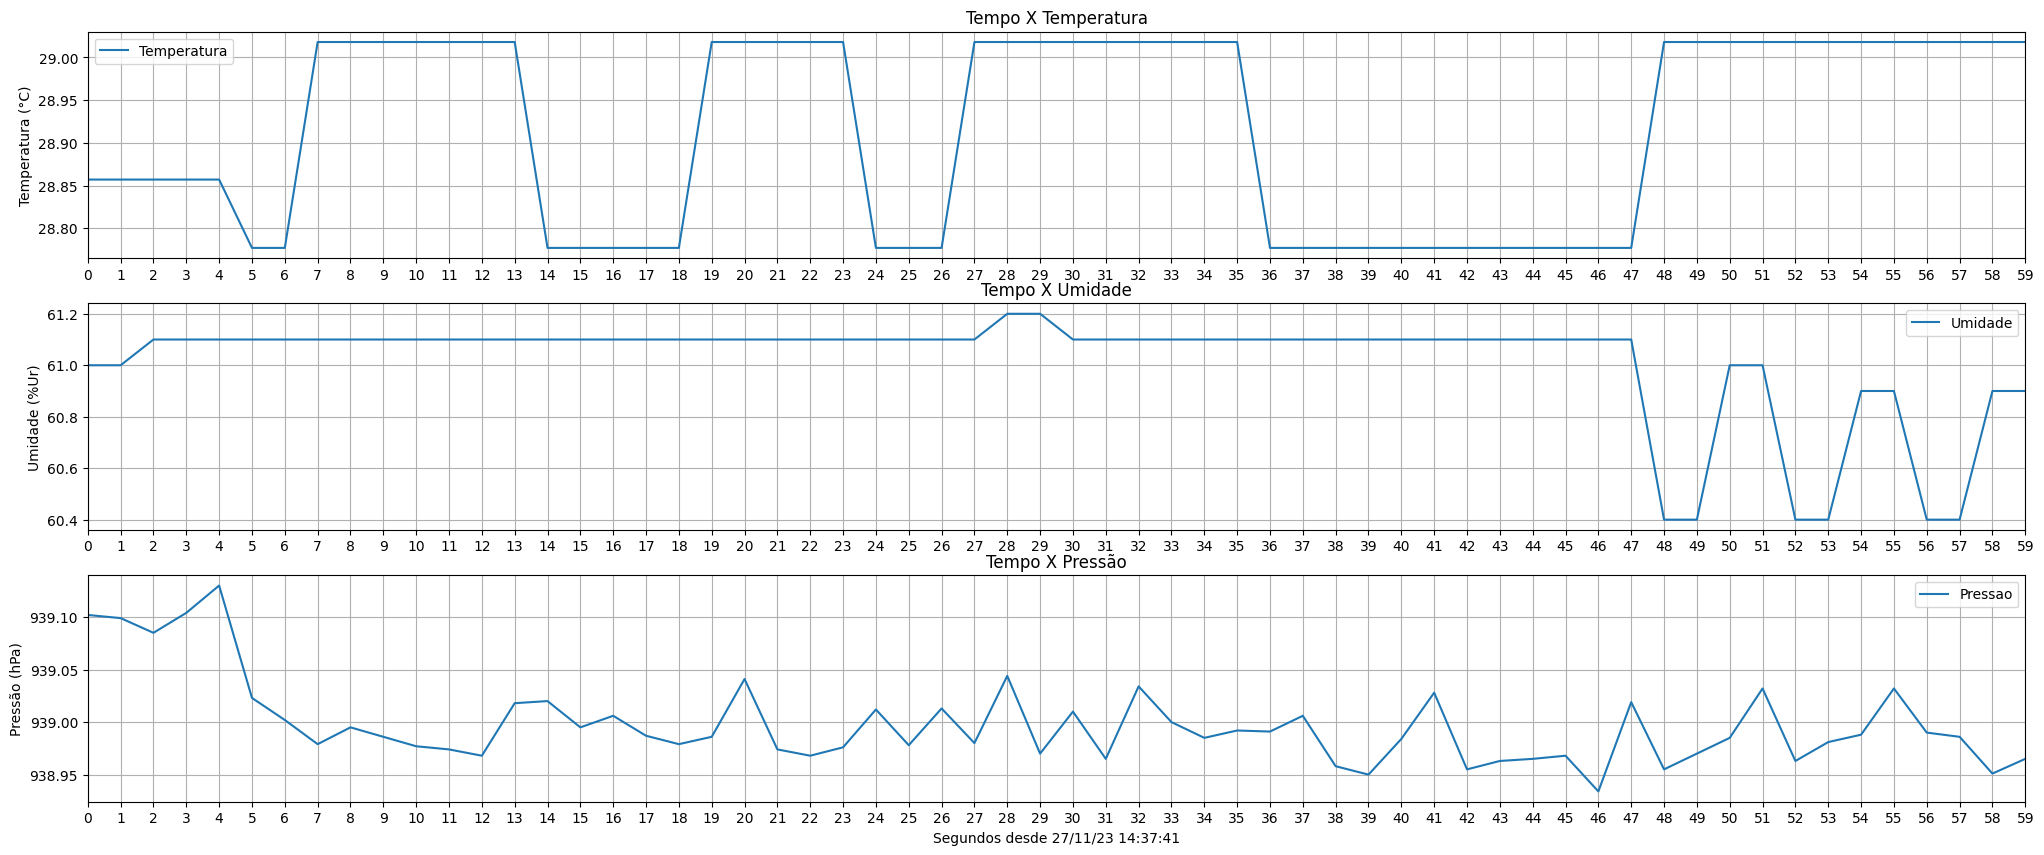

In [4]:
# EXIBIÇÃO DE DADOS

# Define o menu
tipo_upload = 'url' #@param ['direto', 'google_drive', 'url'] {allow-input: false}
caminho_no_gdrive = 'Escola/RCOC6/Trabalho 2/dadosTesteFicticio.csv' #@param {type: 'string'}
url_csv = 'https://raw.githubusercontent.com/RolfE-HR/trab_redes/main/tests/dadosClimaticosGrupoZ.csv' #@param {type: 'string'}

# Nome do arquivo carregado
arquivo_upload = ""

# Se for carregado do Google Drive, monta o Drive do usuário e copia o arquivo
if tipo_upload == 'google_drive':
    drive.mount('/drive')
    shutil.copy('/drive/My Drive/' + caminho_no_gdrive, '.')
    arquivo_upload = os.path.basename(caminho_no_gdrive)
# Já se for um upload direto, pega o arquivo carregado
elif tipo_upload == 'direto':
    uploaded = files.upload()
    for fn in uploaded.keys():
        arquivo_upload = fn
# Caso seja informado um URL, baixa o arquivo informado
elif tipo_upload == 'url':
    !wget -nc $url_csv
    arquivo_upload = os.path.basename(url_csv)

# Leitura do arquivo CSV
df = pd.read_csv(arquivo_upload, sep=';').drop(columns=["Altitude"])
# Mostra o head do dataframe
print(df.tail())

# Salva o tempo da última medida no período
t0 = df['Timestamp'].iloc[-1]
# Subtrai do tempo da segunda leitura para obter a frequencia de coleta de dados
delta_t = t0 - df['Timestamp'].iloc[-2]
print(f"Intervalo de tempo detectado entre as medidas: {delta_t} segundos")

# Seleção do período para visualização dos dados
#@markdown ---
periodo = "Segundos / Ultimo minuto" #@param ["Segundos / Ultimo minuto", "Minutos / Ultima hora", "Horas / Ultimo dia", "Dias / Ultima semana"]

# Dicionário para conversão de segundos para o período selecionado
dict_periodo = {
    "Segundos / Ultimo minuto": [1, 60, "Segundos desde "], # Não é necessário agrupar os dados
    "Minutos / Ultima hora": [60, 60, "Minutos desde "],
    "Horas / Ultimo dia": [3600, 24, "Horas desde um "],
    "Dias / Ultima semana": [86400, 7, "Dias desde "]
}

# Agrupamento dos dados de acordo com o período selecionado
# Se não houver dados suficientes para o período selecionado, exibe uma mensagem de erro
if df.shape[0] < (dict_periodo[periodo][0] // delta_t)*dict_periodo[periodo][1]:
    print("Não há dados suficientes para o período selecionado!")
else:
    # Caso especial para os segundos
    if periodo == "Segundos / Ultimo minuto":
        # Pega o último minuto
        df_periodo = df.tail(dict_periodo[periodo][1] // delta_t)
        # Remove a coluna "Timestamp"
        df_periodo = df_periodo.drop(columns=["Timestamp"])
        # Adiciona um novo index com um incremento de delta_t
        df_periodo['Tempo'] = range(0, 60, delta_t)
        df_periodo.set_index('Tempo', inplace=True)
    else:
        # Agrupa os dados de acordo com o período selecionado e faz a média dos valores
        df_periodo = df.groupby(df.index // (dict_periodo[periodo][0] // delta_t)).mean().tail(dict_periodo[periodo][1])
        # Remove a coluna "Timestamp"
        df_periodo = df_periodo.drop(columns=["Timestamp"])
        # Cria uma coluna com o tempo em minutos/horas/dias
        df_periodo = df_periodo.reset_index(drop=True)

    # Converte o tempo t0
    t0 = datetime.fromtimestamp(t0).strftime("%d/%m/%y %H:%M:%S")

    # Plota os gráficos
    fig, axs = plt.subplots(3, 1)
    df_periodo.plot(y='Temperatura', ax=axs[0], title="Tempo X Temperatura", xlabel="", ylabel="Temperatura (°C)", xlim=[0,dict_periodo[periodo][1]-1], grid=True, xticks=range(0,dict_periodo[periodo][1]), figsize=(25,10))
    df_periodo.plot(y='Umidade', ax=axs[1], title="Tempo X Umidade", xlabel="", ylabel="Umidade (%Ur)", xlim=[0,dict_periodo[periodo][1]-1], grid=True, xticks=range(0,dict_periodo[periodo][1]), figsize=(25,10))
    df_periodo.plot(y='Pressao', ax=axs[2], title="Tempo X Pressão", xlabel=(dict_periodo[periodo][2] + t0), ylabel="Pressão (hPa)", xlim=[0,dict_periodo[periodo][1]-1], grid=True, xticks=range(0,dict_periodo[periodo][1]), figsize=(25,10))
    fig_manager = plt.get_current_fig_manager()
    plt.show()